# Direct Collocation

## Goal
* Go through Python/CasADi implementations for the direct collocation trajectory optimization examples given in Matthew Kelly's tutorial for trajectory optimization \[1\].
* \[1\] goes through the theoretical aspects of direction collocation which will not be discussed here. Instead, this notebook will aim to a give hands-on introduction to implementing the methods discussed there in Python, instead of the MATLAB implementation that Matthew Kelly provides.

## References
* \[1\] [An Introduction to TrajectoryOptimization: How to Do YourOwn Direct Collocation](https://epubs.siam.org/doi/pdf/10.1137/16M1062569) - Matthew Kelly's excellent tutorial, on which all of the contents on this notebook are based off of

## Notation
For the most part, this notebook will follow the notations given in \[1\]:
![kelly_notation](img/kelly_notation.png)

In [1]:
# Import libraries. Install them through pip, conda, etc as necessary
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

## Block Move - Trapezoidal Collocation (Sec. 2)

We will begin by implementing the first and simplest trajectory optimization problem given in \[1\] - the block move problem:

![kelly_blockmove](img/kelly_blockmove.png)

We begin with trapezoidal collocation, since it is the simpler of the two methods discussed in \[1\]. We start by defining some constants for the problem, and initializing our opti object.

In [2]:
# parameters
tf = 1.0 #final time
N = 20 #number of trajectory segments

# initialize NLP
opti = ca.Opti()

Next, we define decision variables, which are the position, velocity, and force applied to the block at each timestep. Note that these decision variables have left and right endpoints for each trajectory segments, so they have dimension $N+1$ rather than $N$. Additionally, we define the variable indicating the time at each timestep, which is not strictly required but is convenient to define.

In [3]:
# decision variables
X = opti.variable(N+1)
V = opti.variable(N+1)
U = opti.variable(N+1)

# time discretization
t = np.linspace(0, tf, N+1)

We first apply the boundary constraints given by (2.7) of \[1\]:
![kelly_blockmove_trapz_boundary](img/kelly_blockmove_trapz_boundary.png)

In [4]:
# boundary constraints
opti.subject_to( X[0] == 0 )
opti.subject_to( X[N] == 1 )
opti.subject_to( V[0] == 0 )
opti.subject_to( V[N] == 0 )

We now iterate through each trajectory segment, applying collocation constraints and generating the cost function.

The collocation constraints are given by equation (2.5) and (2.6) of \[1\]:
![kelly_blockmove_trapz_colloc](img/kelly_blockmove_trapz_colloc.png)

The optimization objective given by (2.8) of \[1\]:
![kelly_blockmove_trapz_objective](img/kelly_blockmove_trapz_objective.png)

In [5]:
# variable for storing the cost function
J = 0;

# iterate over all k = 0,..., N-1. Note that we don't include index N
for i in range(N):
    x_left = X[i]; x_right = X[i+1]
    v_left = V[i]; v_right = V[i+1]
    u_left = U[i]; u_right = U[i+1]
    
    # collocation constraints
    opti.subject_to( x_right-x_left == 0.5*tf/N*(v_right+v_left) )
    opti.subject_to( v_right-v_left == 0.5*tf/N*(u_right+u_left) )
    
    # cost function
    J += 0.5*tf/N*(u_left**2 + u_right**2)

# apply cost function to opti
opti.minimize(J)

Next, we specify an initial guess solution of our NLP, given by (2.12) of \[1\]:
![kelly_blockmove_trapz_init](img/kelly_blockmove_trapz_init.png)

In [6]:
# initial guess
opti.set_initial(X, t)
opti.set_initial(V, np.full(V.shape, 1))
opti.set_initial(U, np.zeros(U.shape))

Finally, we solve the NLP and see what the solution looks like


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      164
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:       63
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality c

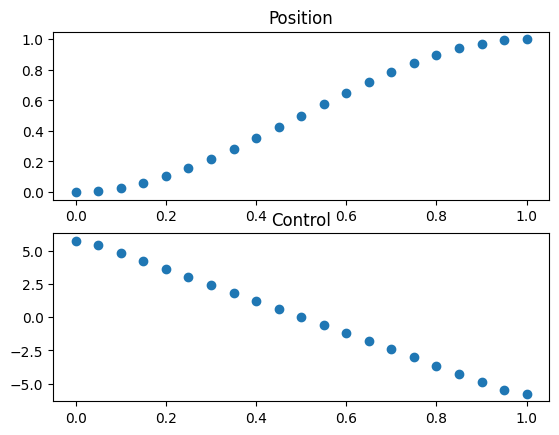

In [7]:
# solve
opti.solver('ipopt')
sol = opti.solve()

# extract solution
sol_t = t
sol_x = sol.value(X)
sol_u = sol.value(U)

# plot
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(sol_t, sol_x, 'o')
ax[0].set_title('Position')
ax[1].plot(sol_t, np.squeeze(sol_u), 'o')
ax[1].set_title('Control')
plt.show()

## Block Move - Hermite-Simpson Collocation (Sec. 4)
Now that we've gone through the simplest example of direct collocation via casadi, we can refine our method now through Hermite-Simpson collocation. We will still solve the same block move example, but will now use a more general method of defining variables that can easily be scaled to much more complex robotic systems.

The implementation below is almost complete. Your task is to complete it by implementing collocation and interpolation constraints, respectively given by equations (4.3) and (4.4):
![kelly_colloc_constraint](img/kelly_colloc_constraint.png)
![kelly_interp_constraint](img/kelly_interp_constraint.png)

Note that the framework below was designed to be used with the seperated form of Hermite-Simpson collocation, which is supposedly better if the number of time segments is small \[1\] (Sec. 4.2).

In [10]:
# parameters
tf = 1.0 #final time
N = 10 #number of trajectory segments
nx = 2 #dimension of state vector
nu = 1 #dimension of control vector

# initialize NLP
opti = ca.Opti()

# decision variables + time discretization
X = opti.variable(nx, 2*N+1)
U = opti.variable(nu, 2*N+1)
t = np.linspace(0, tf, 2*N+1)

# dynamics
def derive_dynamics():
    # dynamics derivations are put into its own function so temporary SX variables can be defined
    x = ca.SX.sym('x', nx)
    u = ca.SX.sym('u', nu)
    xdot = ca.vertcat(x[1], u)
    f = ca.Function('f', [x,u], [xdot])
    return f
f = derive_dynamics()

# objective
simp = np.array([[4*(i%2)+2*((i+1)%2) for i in range(2*N+1)]]) # simpson quadrature coefficient vector
simp[0][0]=1
simp[0][-1]=1
J = ca.dot(simp, U[:,:]*U[:,:])
opti.minimize(J)

# boundary constraints
opti.subject_to( X[:,0] == np.array([0, 0]) )
opti.subject_to( X[:,-1] == np.array([1, 0]) )

# dynamics constraints
for i in range(2*N+1):
    if i%2 != 0:
        x_left, x_mid, x_right = X[:,i-1], X[:,i], X[:,i+1]
        u_left, u_mid, u_right = U[:,i-1], U[:,i], U[:,i+1]
        f_left, f_mid, f_right = f(x_left,u_left), f(x_mid,u_mid), f(x_right,u_right)

        # interpolation constraint
        # TODO: implement eq. 4.4
        # note that index k corresponds to the midpoint, k-1 to the left endpoint, and k+1 to the right
        # endpoint of the current finite element
        opti.subject_to( x_mid == 0.5*(x_left + x_right) + 0.125*(tf/N)*(f_left - f_right))
        
        # collocation constraint
        # TODO: implement eq. 4.3
        opti.subject_to( x_right - x_left == (1/6)*tf/N*(f_left + 4*f_mid + f_right))

# initial guess
opti.set_initial(X, np.vstack((t, np.full(t.shape, 1))))
opti.set_initial(U, np.zeros(U.shape))

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      204
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:       63
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       44
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

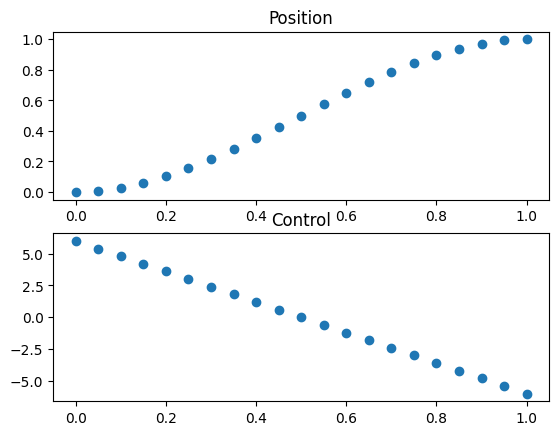

In [11]:
# solve
opti.solver('ipopt')
sol = opti.solve()

# extract solution
sol_t = t
sol_x = sol.value(X)
sol_u = sol.value(U)

# plot
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(sol_t, sol_x[0], 'o')
ax[0].set_title('Position')
ax[1].plot(sol_t, np.squeeze(sol_u), 'o')
ax[1].set_title('Control')
plt.show()

## Cartpole (Sec. 6)

Now we are ready to implement Hermite-Simpson collocation for the carpole swing up problem.

![kelly_cartpole](img/kelly_cartpole.png)

![kelly_cartpole_NLP](img/kelly_cartpole_NLP.png)

Your task is, given the framework given below, fill in the sections indicated with `TODO`. Note that because of the generality of the programming method used in the blockmove Hermite-Simpson implementation, most of the code looks the same as before.

One thing to note is that the derivation of the dynamics follows that given in [Russ Tedrake's notes on Underactuated Robotics](http://underactuated.mit.edu/acrobot.html#cart_pole), which is different from the scalar method given in \[1\]. This form of formulating dynamics, where you apply Lagrangian mechanics to obtain the equations of motion in standard manipulator equation form, can be directly applied to much more complicated robotic systems.

In [21]:
# parameters
tf = 2.0 #final time
N = 25 #number of trajectory segments
nx = 4 #dimension of state vector
nu = 1 #dimension of control vector

x_init = [0.0, 0.0, 0.0, 0.0] #intial state
x_final = [1.0, np.pi, 0.0, 0.0] #final state

m1 = 1.0 #cart mass
m2 = 0.3 #pendulum mass
l = 0.5 #pendulum length
g = 9.81 #gravity
u_max = 10.0 #maximum actuator force
d_max = 2.0 #extent of rail that cart travels on

# initialize NLP
opti = ca.Opti()

# decision variables + time discretization
X = opti.variable(nx, 2*N+1)
U = opti.variable(nu, 2*N+1)
t = np.linspace(0, tf, 2*N+1)

# dynamics
def derive_dynamics():
    # dynamics derivations are put into its own function so temporary SX variables can be defined
    x = ca.SX.sym('x', nx)
    u = ca.SX.sym('u', nu)
    M = ca.SX(np.array([ \
        [m1 + m2, m2*l*ca.cos(x[1])],
        [m2*l*ca.cos(x[1]), m2*l**2]
        ]))
    C = ca.SX(np.array([ \
        [0.0, -m2*l*x[3]*ca.sin(x[1])],
        [0.0, 0.0]
        ]))
    tau_g = ca.SX(np.array([ \
        [0.0],
        [-m2*g*l*ca.sin(x[1])]
        ]))
    B = ca.SX(np.array([ \
        [1.0],
        [0.0]
        ]))
    xdot = ca.vertcat( \
        x[2:],
        ca.solve(M, -C@x[2:]+tau_g+B@u)
        )
    f = ca.Function('f', [x,u], [xdot])
    return f
f = derive_dynamics()

# objective
simp = np.array([[4*(i%2)+2*((i+1)%2) for i in range(2*N+1)]]) # simpson quadrature coefficient vector
simp[0][0]=1
simp[0][-1]=1
J = ca.dot(simp, U[:,:]*U[:,:])
opti.minimize(J)

# boundary constraints
opti.subject_to( X[:,0] == x_init )
opti.subject_to( X[:,-1] == x_final )

# dynamics constraints
for i in range(2*N+1):
    if i%2 != 0:
        x_left, x_mid, x_right = X[:,i-1], X[:,i], X[:,i+1]
        u_left, u_mid, u_right = U[:,i-1], U[:,i], U[:,i+1]
        f_left, f_mid, f_right = f(x_left,u_left), f(x_mid,u_mid), f(x_right,u_right)

        # interpolation constraint
        # TODO: implement (6.11)
        opti.subject_to( x_mid == 0.5*(x_left + x_right) + 0.125*(tf/N)*(f_left - f_right))

        
        # collocation constraint
        # TODO: implement (6.12)
        opti.subject_to( x_right - x_left == (1/6)*tf/N*(f_left + 4*f_mid + f_right))
        

# path constraint on state
# TODO: implement (6.13), using the given value of d_max
# hint: opti.bounded could be useful here
opti.subject_to(opti.bounded(-d_max, X[0,:], d_max))

# path constraint on control
# TODO: implement (6.14), using the given value of u_max
# hint: opti.bounded could be useful here
opti.subject_to(opti.bounded(-u_max, U[0,:], u_max))
        
#decision variable initial guess
opti.set_initial(X, np.linspace(x_init, x_final, 2*N+1).T) #linear interpolation on state
opti.set_initial(U, np.zeros(U.shape)) #zero control

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1408
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      255

Total number of variables............................:      255
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      208
Total number of inequality constraints...............:      102
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      102
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.57e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

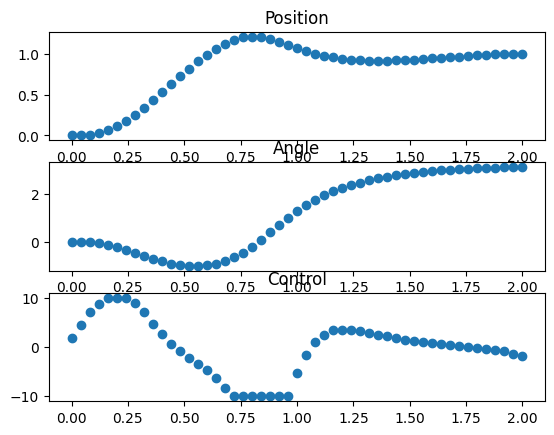

In [22]:
# solve
opti.solver('ipopt')
sol = opti.solve()

# extract solution
sol_t = t
sol_x = sol.value(X)
sol_u = sol.value(U)

# plot
fig, ax = plt.subplots(nrows=3, ncols=1)
ax[0].plot(sol_t, sol_x[0], 'o')
ax[0].set_title('Position')
ax[1].plot(sol_t, sol_x[1], 'o')
ax[1].set_title('Angle')
ax[2].plot(sol_t, np.squeeze(sol_u), 'o')
ax[2].set_title('Control')
plt.show()

In the exercise above, hopefully you got something similar to the plot below. Note that you'll get this result even without the path constraints. Test that the path constraints are working by setting `u_max=10`. You should now get the second plot shown below (or at least this is what I got).
![kelly_cartpole_result](img/kelly_cartpole_result.png)
![cartpole_result_10umax](img/cartpole_result_10umax.png)